In [ ]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [ ]:
# !kaggle datasets download -d marquis03/vehicle-classification

In [ ]:
# !unzip vehicle-classification.zip -d "/content/drive/MyDrive/Google Colab Notebooks/datasets/vehicle classification"

### Importing Libraries

In [161]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import layers, models, optimizers, losses, metrics
import os
import numpy as np
import matplotlib.pyplot as plt

### Setting up directory paths

In [162]:
base_dir = "/content/drive/MyDrive/Google Colab Notebooks/Projects"
ds_path = "/content/drive/MyDrive/Google Colab Notebooks/datasets/vehicle classification"
model_dir_path = "/content/drive/MyDrive/Google Colab Notebooks/models"

In [163]:
os.listdir(ds_path)

['test', 'train', 'val']

In [164]:
test_files,train_ds_path,val_ds_path = [os.path.join(ds_path,dir) for dir in os.listdir(ds_path)]

In [165]:
os.listdir(train_ds_path)

['SUV',
 'bus',
 'family sedan',
 'fire engine',
 'heavy truck',
 'jeep',
 'minibus',
 'racing car',
 'taxi',
 'truck']

In [166]:
os.listdir(val_ds_path)

['SUV',
 'bus',
 'family sedan',
 'fire engine',
 'heavy truck',
 'jeep',
 'minibus',
 'racing car',
 'taxi',
 'truck']

In [167]:
len(os.listdir(test_files))

200

### Defining constants

In [170]:
IMAGE_SIZE = (224,224,)
BATCH_SIZE = 64

### Data Augmentation generator

In [171]:
train_data_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 15,
    brightness_range = (0.7,1.3),
    zoom_range = (0.9,1.1),
    horizontal_flip = True,
    shear_range = 0.2
)
validation_data_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0
)

### Loading dataset in batches

In [172]:
train_ds = train_data_generator.flow_from_directory(
    train_ds_path,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = True
)

Found 1400 images belonging to 10 classes.


In [173]:
val_ds = validation_data_generator.flow_from_directory(
    val_ds_path,
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 200 images belonging to 10 classes.


In [174]:
test_ds = utils.image_dataset_from_directory(
    test_files,
    labels = None,
    image_size = IMAGE_SIZE,
    seed = 21
)

Found 200 files belonging to 1 classes.


### Class labels

In [175]:
class_indices = train_ds.class_indices
class_indices

{'SUV': 0,
 'bus': 1,
 'family sedan': 2,
 'fire engine': 3,
 'heavy truck': 4,
 'jeep': 5,
 'minibus': 6,
 'racing car': 7,
 'taxi': 8,
 'truck': 9}

In [176]:
idx2class = {value:key for key,value in class_indices.items()}
idx2class

{0: 'SUV',
 1: 'bus',
 2: 'family sedan',
 3: 'fire engine',
 4: 'heavy truck',
 5: 'jeep',
 6: 'minibus',
 7: 'racing car',
 8: 'taxi',
 9: 'truck'}

In [177]:
num_classes = train_ds.num_classes
num_classes

10

In [178]:
test_images = [os.path.join(test_files,image_name) for image_name in os.listdir(test_files)]
test_images[:2]

['/content/drive/MyDrive/Google Colab Notebooks/datasets/vehicle classification/test/01ab0c4e74e5cefbc25e78e8b2b4b30d.jpg',
 '/content/drive/MyDrive/Google Colab Notebooks/datasets/vehicle classification/test/02a43a441f5c71ab9ff8ecab1f33ca49.jpg']

### Loading resnet50 model

In [179]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [180]:
resnet50_model = ResNet50(include_top = False,weights="imagenet", input_shape=(224,224,3))

In [181]:
for layer in resnet50_model.layers:
  layer.trainable = False

### Augmented images

In [182]:
x = None
for i in train_ds:
  x = i
  break

In [183]:
t = x[0]
v = x[1]

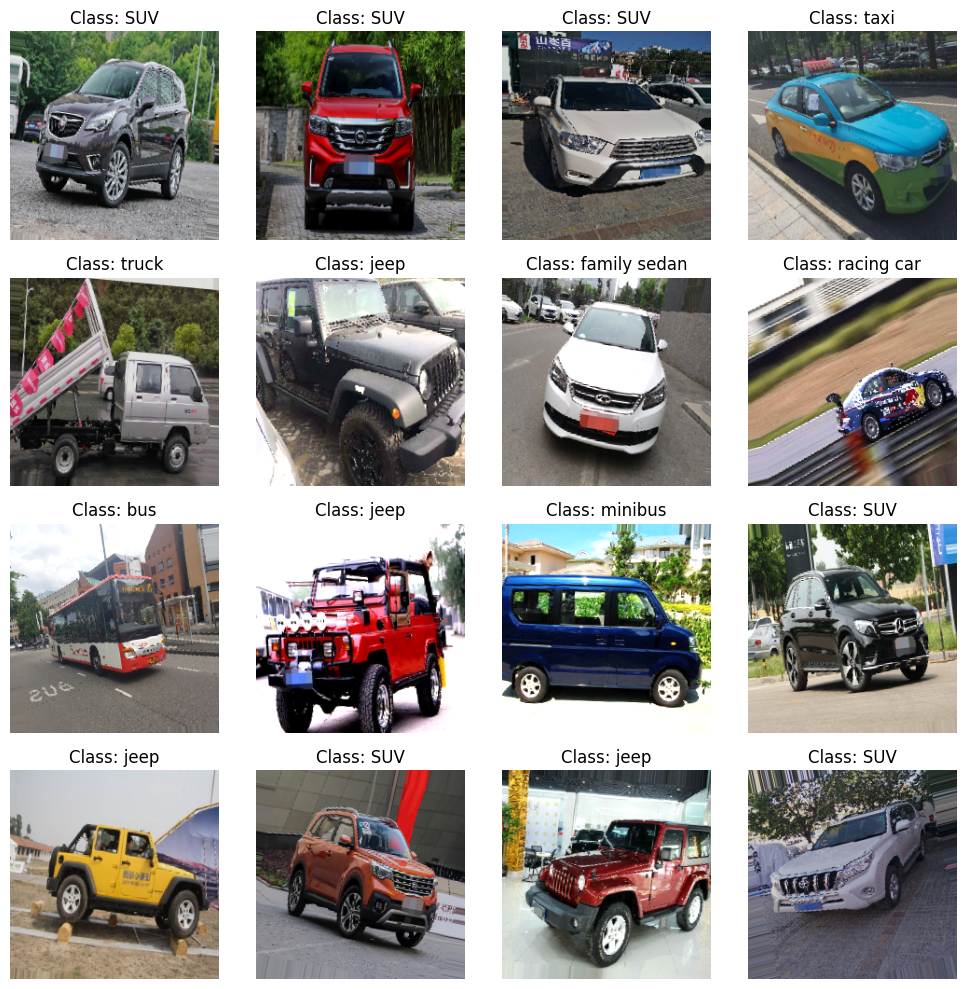

In [184]:
plt.figure(figsize=(10,10))
for index, image in enumerate(t):
  if index == 16:
    break
  label = v[index]
  actual_class = idx2class[np.argmax(label)]
  plt.subplot(4,4,index+1)
  plt.imshow(image)
  plt.title(f"Class: {actual_class}")
  plt.axis('off')
plt.tight_layout()
plt.show()

### Defining optimizers and loss functions

In [185]:
optimizer = optimizers.Adam()
loss_function = losses.CategoricalCrossentropy()
accu_metric = metrics.CategoricalAccuracy(name="accuracy")

### Vehicle Classifier

In [186]:
x = resnet50_model.output
x = layers.Flatten()(x)
x = layers.Dense(num_classes,activation="softmax")(x)
vehicle_classifier = tf.keras.Model(inputs=resnet50_model.input,outputs=x)

In [187]:
vehicle_classifier.compile(
    loss = loss_function,
    optimizer = optimizer,
    metrics = [accu_metric]
)

In [188]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir_path,"vehicle_classifier_epoch_{epoch}_checkpoint.weights.h5"),
    monitor="val_loss",
    verbose=0,
    mode='min',
    save_best_only=True,
    save_weights_only=True
)
callbacks = [model_checkpoint,early_stopping]

In [192]:
# vehicle_classifier.load_weights(os.path.join(model_dir_path,"vehicle_classifier_epoch_17_checkpoint.weights.h5"))

In [194]:
# vehicle_classifier_history = vehicle_classifier.fit(
#     train_ds,
#     validation_data=val_ds,
#     batch_size=BATCH_SIZE,
#     epochs=10,
#     callbacks=callbacks)

## Saving model

In [ ]:
# vehicle_classifier.save(os.path.join(model_dir_path,"vehicle_classifier_v2.h5"))

In [203]:
loaded_model = models.load_model(os.path.join(model_dir_path,"vehicle_classifier_v2.h5"))

In [205]:
loaded_model.load_weights(os.path.join(model_dir_path,"vehicle_classifier_epoch_17_checkpoint.weights.h5"))

### Testing

In [199]:
def test_model(model):
  plt.figure(figsize=(10,10))
  for i in range(16):
    image_path = test_images[np.random.randint(0,len(test_images))]
    random_image = preprocessing.image.load_img(image_path,target_size=IMAGE_SIZE)
    random_image = preprocessing.image.img_to_array(random_image)
    random_image = np.expand_dims(random_image,axis=0)
    random_image /= 255
    actual_class = ""
    predicted_class = idx2class[np.argmax(model.predict(random_image,verbose=0))]
    plt.subplot(4,4,i+1)
    plt.imshow(random_image[0])
    plt.title(f"Actual class: {actual_class}\n Predicted class: {predicted_class}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
test_model(loaded_model)

In [213]:
x = None
for i in val_ds:
  x = i
  break

In [214]:
t = x[0]
v = x[1]

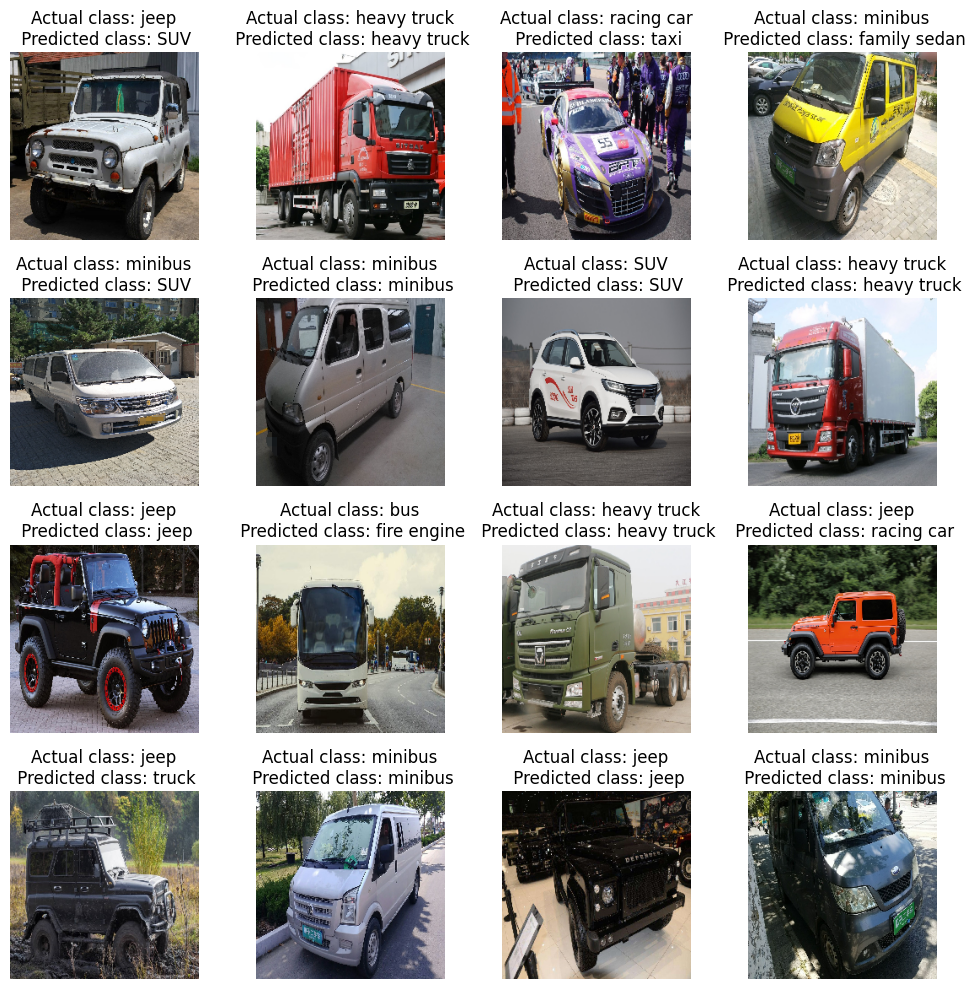

In [215]:
plt.figure(figsize=(10,10))
for index, image in enumerate(t):
  if index == 16:
    break
  label = v[index]
  actual_class = idx2class[np.argmax(label)]
  predicted_class = idx2class[np.argmax(loaded_model.predict(np.expand_dims(image,0),verbose=0))]
  plt.subplot(4,4,index+1)
  plt.imshow(image)
  plt.title(f"Actual class: {actual_class}\n Predicted class: {predicted_class}")
  plt.axis('off')
plt.tight_layout()
plt.show()